In [362]:
# Imports
from typing import List

import pandas
import numpy as np

## Assumed steps
#### Benchmark
    - dataset_v0
        # EVALUATE 
        - [catboost_v0] untuned classifier on dataset_v0 data set (~75% accuracy)
        - [catboost_v1] tuned classifier on dataset_v0 data set
        
####  Data set Preprocessing
    - dataset_v1
        - data cleaning
            - ignore the tuples 
            - missing values
                - fill with mean | meadian | custom
            - elinimate noise data 
                - binning method & regression & clustering 
        - data transformation
            - normalization
            - attribute selection
            - discretization # muted
        - data reduction # muted
        
### CAVEATS 
- Imbalanced target (700 vs 300) # resolved within shuffling # could be applied sampling as well
- Odd mean loan of creditors age of > 65 


### Steps
1. Rename columns names for explicit visual understanding of features  

In [267]:
class Transformer:
    @staticmethod
    def rename_columns(dataset: pd.DataFrame):
        """Rename dataframe columns names.
        Notes:
            target column names based on provided data_description.txt
        Returns:
            pd.DataFrame - dataframe with renamed columns 
        """
    
        target_columns = {
            'X01': 'account_status',
            'X06': 'account_savings',
            'X02': 'credit_duration',
            'X03': 'credit_history',
            'X04': 'credit_purpose',
            'X05': 'credit_amount',
            'X07': 'employment_status',
            'X17': 'employment_description',
            'X08': 'income_installment_rate',
            'X09': 'gender_status',
            'X10': 'credit_guarantors',
            'X11': 'residence',
            'X12': 'owned_property',
            'X13': 'age',
            'X14': 'installment_plans',
            'X15': 'accomondation_type',
            'X16': 'credit_existing_number',
            'X18': 'liable_maintain',
            'X19': 'phone_number',
            'X20': 'foreign_worker',
            'Y': 'y'
        }
        return dataset.rename(columns=target_columns)    
    
    @staticmethod
    def categorical_columns(dataset: pd.DataFrame):
        """Within dataset find categorical columns
        
        Returns:
          List: list of names of categorical columns.
        """
        categorical_columns_indexes = []
        
        columns = dataset.columns
        num_columns = dataset._get_numeric_data().columns # get numerical columns
        
        categorical_columns = sorted(list(set(columns) - set(num_columns)))
        categorical_columns_indexes = [dataset.columns.get_loc(column) for column in categorical_columns]
        return categorical_columns, categorical_columns_indexes
          
    @staticmethod
    def train_test_split(dataset: pd.DataFrame, test_size: int, shuffle=False):
        from sklearn.model_selection import train_test_split
        print(f'Splitting dataset {dataset.shape} with test_size :{test_size}')
        X = dataset.drop(columns=['y'])
        y = dataset['y']
        X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=shuffle, test_size=test_size)
        print(f'X_train: {X_train.shape}')
        print(f'y_train: {y_train.shape}')
        print(f'X_test: {X_test.shape}')
        print(f'y_test: {y_test.shape}')
        return X_train, X_test, y_train, y_test
    
    @staticmethod
    def custom_split(dataset: pd.DataFrame, test_percentage: int):
        size = dataset.shape[0]
        train_ratio = (size * test_percentage) // 100
        test_ratio = size - train_ratio

        X_train = pd.DataFrame(dataset[:train_ratio, :-1])
        X_test = pd.DataFrame(dataset[:test_ratio, :-1])

        y_train = dataset[:train_ratio, -1]
        y_test = dataset[:test_ratio, -1]
        return X_train, X_test, y_train, y_test
    
    @staticmethod
    def data_cleaning(dataframe: pd.DataFrame):
        """Applies follwoing transformations:   
            - data cleaning
                - ignore the tuples # when the dataset is large and multiple values are missing within a tuple.
                - missing values
                    - fill with mean | meadian | custom
                - encoding
        """
        categorical_columns = [column for column in dataset_v1.columns if dataset_v1[f'{column}'].dtype == 'object']
    
        for column_name in categorical_columns: 
            labels = dataframe[f'{column_name}'].astype('category').cat.categories.tolist()
            replace_map_comp = {f'{column_name}' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
            dataframe.replace(replace_map_comp, inplace=True)
        return dataframe
    
    @staticmethod
    def data_transformation(dataframe: pd.DataFrame, features=20):
        """Applies follwoing transformations:
            - data transformation
                - normalization # preprocessing.MinMaxScaler()
                - attribute selection # SelectKBest(chi2, k=features)
                - discretization # muted for now 
        """
        from sklearn import preprocessing
        from sklearn.feature_selection import chi2
        from sklearn.feature_selection import SelectKBest
        original_columns = ['account_status', 'credit_duration', 'credit_history', 'credit_purpose', 'credit_amount', 'account_savings',
                            'employment_status', 'income_installment_rate', 'gender_status','credit_guarantors', 'residence', 'owned_property', 'age',
                            'installment_plans', 'accomondation_type', 'credit_existing_number', 'employment_description',
                            'liable_maintain', 'phone_number', 'foreign_worker', 'y'
                           ]
        
        values = dataframe.values #returns a numpy array
        min_max_scaler = preprocessing.MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(values)
        buff_df = pd.DataFrame(x_scaled)
        
        buff_df.columns = original_columns # cast back original column namings 
        
        X = buff_df.drop(columns=['y'], axis=1)
        y = buff_df['y']
        
        dataframe = SelectKBest(chi2, k=features).fit_transform(X, y)
        return dataframe
    

In [300]:
class Models:
    @staticmethod
    def _catboost_classifier(X_train, X_test, y_train, y_test, cat_features, hparams=False):
        """CatBoost Classifier.
        
        Notes:
          - cat_features: CatBoost model requires list of indexes which denote categorical columns;
        """
        from catboost import CatBoostClassifier, Pool
        from sklearn.metrics import accuracy_score
        from sklearn.model_selection import GridSearchCV
        
        if hparams == False:
            train_data = Pool(
                data=X_train.values,
                label=y_train,
                cat_features=cat_features
            )
            model = CatBoostClassifier(iterations=30)
            model.fit(train_data)
            
            predictions = model.predict(X_test.values)
            accuracy = accuracy_score(y_test, predictions)
            return accuracy
        
        else:
            model = CatBoostClassifier()
            
            grid = {
                'learning_rate': [0.03, 0.1],
                'depth': [4, 6, 10],
                'l2_leaf_reg': [1, 3, 5, 7, 9]
            }
            grid = GridSearchCV(estimator=model,
                                param_grid=grid,
                                cv=3,
                                n_jobs=-1
                               )
            grid.fit(X_train, y_train)
            predictions = grid.best_estimator_.predict(X_test.values)
            accuracy = accuracy_score(y_test, predictions)
            return accuracy
                    
        
    @staticmethod
    def _xgboost_classifier(X_train, X_test, y_train, y_test, hparams=False):
        """Apply XGBoost Classifier.
        Notes:
          When using XGBoost we need to convert categorical variables into numeric.
        """
        from xgboost import XGBClassifier
        from sklearn.metrics import accuracy_score
        # untuned model
        if hparams==False:
            model = XGBClassifier()
            model.fit(X_train, y_train, verbose=True)
            predictions = model.predict(X_test)
            accuracy = accuracy_score(y_test, predictions)
        
        # tuned model
        else:
            model = XGBClassifier(silent=False, 
                                  scale_pos_weight=1,
                                  learning_rate=0.01,  
                                  subsample = 0.8,
                                  objective='binary:logistic', 
                                  n_estimators=100, 
                                  reg_alpha = 0.3,
                                  max_depth=2,
                                  seed=42
                                 )
            
            model.fit(X_train, y_train, verbose=True)
            predictions = model.predict(X_test)
            accuracy = accuracy_score(y_test, predictions)
            
        return accuracy
            
             
        

## Entry Point

In [301]:
models = Models()
transformer = Transformer()


row_data = pd.read_csv('./dataset/project_data.csv', delimiter=';')
# print(row_data)


# # Benchmark
dataset_v0 = transformer.rename_columns(row_data)
categorical_columns, categorical_columns_indexes = transformer.categorical_columns(dataset_v0) 
X_train_v0, X_test_v0, y_train_v0, y_test_v0 = transformer.train_test_split(dataset_v0,
                                                                            test_size=.3,
                                                                            shuffle=True
                                                                           )

# - dataset_v0 && - [catboost_v0] untuned classifier on dataset_v0 data set (~75% accuracy)
dataset_v0_catboost_v0 = models._catboost_classifier(X_train_v0,
                                                     X_test_v0,
                                                     y_train_v0,
                                                     y_test_v0,
                                                     cat_features=categorical_columns_indexes,
                                                     hparams=False
                                                    )


# Beating Benchmark
dataset_v1 = transformer.rename_columns(row_data)
dataset_v1 = transformer.data_cleaning(dataset_v1)
dataset_v1 = transformer.data_transformation(dataset_v1, features=5) # return ndarray
X_train_v1, X_test_v1, y_train_v1, y_test_v1 = transformer.custom_split(dataset_v1,
                                                                        test_percentage=30
                                                                       )


# - dataset_v1 && - [catboost_v0] untuned classifier 
dataset_v1_catboost_v0 = models._catboost_classifier(X_train_v1,
                                                     X_test_v1,
                                                     y_train_v1,
                                                     y_test_v1,
                                                     cat_features=[],
                                                     hparams=False
                                                    )

# - dataset_v1 && - [xgboost_classifier_v0] untuned classifier
dataset_v1_xgboost_classifier_v0 = models._xgboost_classifier(X_train_v1,
                                                              X_test_v1,
                                                              y_train_v1,
                                                              y_test_v1,
                                                              hparams=False
                                                             )

# - dataset_v1 && - [catboost_v1] tuned classifier 
dataset_v1_catboost_v1 = models._catboost_classifier(X_train_v1,
                                                     X_test_v1,
                                                     y_train_v1,
                                                     y_test_v1,
                                                     cat_features=[],
                                                     hparams=True
                                                    )

# - dataset_v1 && - [xgboost_classifier_v1] tuned classifier
dataset_v1_xgboost_classifier_v1 = models._xgboost_classifier(X_train_v1,
                                                              X_test_v1,
                                                              y_train_v1,
                                                              y_test_v1,
                                                              hparams=True
                                                             )


Splitting dataset (1000, 21) with test_size :0.3
X_train: (700, 20)
y_train: (700,)
X_test: (300, 20)
y_test: (300,)
Learning rate set to 0.22043
0:	learn: 0.6381780	total: 4.05ms	remaining: 118ms
1:	learn: 0.5854368	total: 7.81ms	remaining: 109ms
2:	learn: 0.5350906	total: 11.5ms	remaining: 104ms
3:	learn: 0.5162076	total: 15.6ms	remaining: 102ms
4:	learn: 0.4950913	total: 18.6ms	remaining: 93.2ms
5:	learn: 0.4806626	total: 21.7ms	remaining: 87ms
6:	learn: 0.4732264	total: 24.5ms	remaining: 80.5ms
7:	learn: 0.4553043	total: 27.8ms	remaining: 76.4ms
8:	learn: 0.4410464	total: 31.4ms	remaining: 73.2ms
9:	learn: 0.4298926	total: 34.8ms	remaining: 69.7ms
10:	learn: 0.4193115	total: 38.2ms	remaining: 66ms
11:	learn: 0.4105709	total: 41.2ms	remaining: 61.8ms
12:	learn: 0.4043696	total: 44.7ms	remaining: 58.5ms
13:	learn: 0.4023140	total: 46.4ms	remaining: 53ms
14:	learn: 0.3967619	total: 49ms	remaining: 49ms
15:	learn: 0.3899739	total: 51.9ms	remaining: 45.4ms
16:	learn: 0.3797035	total: 54

190:	learn: 0.0354563	total: 178ms	remaining: 756ms
191:	learn: 0.0353622	total: 180ms	remaining: 756ms
192:	learn: 0.0353008	total: 181ms	remaining: 757ms
193:	learn: 0.0352508	total: 182ms	remaining: 756ms
194:	learn: 0.0352203	total: 183ms	remaining: 756ms
195:	learn: 0.0351824	total: 184ms	remaining: 755ms
196:	learn: 0.0351437	total: 185ms	remaining: 754ms
197:	learn: 0.0350811	total: 186ms	remaining: 753ms
198:	learn: 0.0350385	total: 187ms	remaining: 754ms
199:	learn: 0.0350043	total: 188ms	remaining: 754ms
200:	learn: 0.0349646	total: 190ms	remaining: 754ms
201:	learn: 0.0349292	total: 191ms	remaining: 754ms
202:	learn: 0.0348480	total: 192ms	remaining: 754ms
203:	learn: 0.0348177	total: 193ms	remaining: 753ms
204:	learn: 0.0347678	total: 194ms	remaining: 754ms
205:	learn: 0.0347423	total: 196ms	remaining: 755ms
206:	learn: 0.0347028	total: 197ms	remaining: 755ms
207:	learn: 0.0346686	total: 198ms	remaining: 755ms
208:	learn: 0.0346451	total: 199ms	remaining: 754ms
209:	learn: 

360:	learn: 0.0312936	total: 358ms	remaining: 633ms
361:	learn: 0.0312860	total: 359ms	remaining: 632ms
362:	learn: 0.0312790	total: 360ms	remaining: 632ms
363:	learn: 0.0312737	total: 361ms	remaining: 631ms
364:	learn: 0.0312663	total: 362ms	remaining: 631ms
365:	learn: 0.0312563	total: 363ms	remaining: 629ms
366:	learn: 0.0312421	total: 364ms	remaining: 628ms
367:	learn: 0.0312303	total: 366ms	remaining: 629ms
368:	learn: 0.0312209	total: 367ms	remaining: 628ms
369:	learn: 0.0312115	total: 369ms	remaining: 628ms
370:	learn: 0.0312062	total: 370ms	remaining: 627ms
371:	learn: 0.0311955	total: 371ms	remaining: 626ms
372:	learn: 0.0311862	total: 372ms	remaining: 625ms
373:	learn: 0.0311772	total: 373ms	remaining: 624ms
374:	learn: 0.0311684	total: 374ms	remaining: 623ms
375:	learn: 0.0311634	total: 376ms	remaining: 623ms
376:	learn: 0.0311587	total: 377ms	remaining: 622ms
377:	learn: 0.0311518	total: 378ms	remaining: 622ms
378:	learn: 0.0311413	total: 379ms	remaining: 620ms
379:	learn: 

678:	learn: 0.0297182	total: 691ms	remaining: 327ms
679:	learn: 0.0297172	total: 693ms	remaining: 326ms
680:	learn: 0.0297155	total: 694ms	remaining: 325ms
681:	learn: 0.0297113	total: 695ms	remaining: 324ms
682:	learn: 0.0297099	total: 696ms	remaining: 323ms
683:	learn: 0.0297057	total: 698ms	remaining: 322ms
684:	learn: 0.0297019	total: 699ms	remaining: 321ms
685:	learn: 0.0296992	total: 700ms	remaining: 320ms
686:	learn: 0.0296957	total: 701ms	remaining: 319ms
687:	learn: 0.0296929	total: 702ms	remaining: 318ms
688:	learn: 0.0296886	total: 703ms	remaining: 318ms
689:	learn: 0.0296866	total: 704ms	remaining: 316ms
690:	learn: 0.0296856	total: 705ms	remaining: 315ms
691:	learn: 0.0296836	total: 706ms	remaining: 314ms
692:	learn: 0.0296826	total: 707ms	remaining: 313ms
693:	learn: 0.0296810	total: 709ms	remaining: 312ms
694:	learn: 0.0296772	total: 710ms	remaining: 311ms
695:	learn: 0.0296757	total: 711ms	remaining: 310ms
696:	learn: 0.0296734	total: 712ms	remaining: 310ms
697:	learn: 

845:	learn: 0.0294277	total: 868ms	remaining: 158ms
846:	learn: 0.0294253	total: 870ms	remaining: 157ms
847:	learn: 0.0294240	total: 871ms	remaining: 156ms
848:	learn: 0.0294222	total: 872ms	remaining: 155ms
849:	learn: 0.0294210	total: 873ms	remaining: 154ms
850:	learn: 0.0294192	total: 874ms	remaining: 153ms
851:	learn: 0.0294179	total: 875ms	remaining: 152ms
852:	learn: 0.0294169	total: 876ms	remaining: 151ms
853:	learn: 0.0294159	total: 877ms	remaining: 150ms
854:	learn: 0.0294153	total: 878ms	remaining: 149ms
855:	learn: 0.0294148	total: 879ms	remaining: 148ms
856:	learn: 0.0294137	total: 881ms	remaining: 147ms
857:	learn: 0.0294125	total: 882ms	remaining: 146ms
858:	learn: 0.0294114	total: 883ms	remaining: 145ms
859:	learn: 0.0294090	total: 884ms	remaining: 144ms
860:	learn: 0.0294071	total: 885ms	remaining: 143ms
861:	learn: 0.0294059	total: 886ms	remaining: 142ms
862:	learn: 0.0294050	total: 887ms	remaining: 141ms
863:	learn: 0.0294040	total: 888ms	remaining: 140ms
864:	learn: 

In [318]:
# model_version > 0, denones tuned model

results = [[dataset_v0_catboost_v0,
           dataset_v1_catboost_v0, 
           dataset_v1_catboost_v1, # tuned
           dataset_v1_xgboost_classifier_v0,
           dataset_v1_xgboost_classifier_v1 # tuned
          ]] 

result_df = pd.DataFrame(results,
                         columns=['dataset_v0_catboost_v0',
                                  'dataset_v1_catboost_v0',
                                  'dataset_v1_catboost_v1',
                                  'dataset_v1_xgboost_classifier_v0',
                                  'dataset_v1_xgboost_classifier_v1'],
                        index=['accuracy'])
result_df

,dataset_v0_catboost_v0,dataset_v1_catboost_v0,dataset_v1_catboost_v1,dataset_v1_xgboost_classifier_v0,dataset_v1_xgboost_classifier_v1
accuracy,0.736667,0.962857,0.968571,0.967143,0.962857


### Cluster customers into various groups

In [ ]:
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [329]:
kmeans = KMeans(
    init="random",
    n_clusters=3,
    n_init=10,
    max_iter=300,
    random_state=42
)

In [333]:
kmeans.fit(X_train_v1)
print('The lowest SSE value:', kmeans.inertia_)
print('Final locations of the centroid:', kmeans.cluster_centers_)
print('The number of iterations required to converge:', kmeans.n_iter_)
print(kmeans.labels_)

The lowest SSE value: 55.691492877502505
Final locations of the centroid: [[0.63849765 0.25600663 0.66549296 0.94014085]
 [0.95087719 0.20727554 0.65526316 0.09736842]
 [0.16915423 0.27820457 0.61380597 0.06902985]]
The number of iterations required to converge: 4
[0 2 1 2 2 0 1 2 0 2 2 2 2 2 2 2 0 0 2 1 1 2 2 2 0 2 1 0 2 2 0 2 2 0 1 2 1
 1 1 2 1 2 2 2 2 1 1 2 1 1 0 2 1 0 2 0 0 1 1 2 2 0 2 2 1 0 1 0 1 0 1 0 2 2
 0 2 2 2 0 2 0 1 1 2 2 1 2 2 2 2 1 2 0 0 0 2 0 2 2 0 1 2 1 2 0 2 1 2 0 2 2
 1 2 1 2 0 0 0 2 2 2 1 1 1 0 2 2 2 2 2 0 2 1 1 1 0 0 2 0 1 0 2 2 2 1 2 2 1
 2 0 1 1 1 0 2 2 2 2 2 0 1 1 1 2 1 1 2 0 1 2 2 1 2 2 2 0 2 2 1 2 1 2 0 0 2
 1 2 2 2 2 0 2 2 1 2 2 1 2 0 2 1 2 1 2 1 2 1 2 2 0 0 0 2 1 0 0 2 1 2 1 2 0
 1 0 1 1 0 2 1 2 1 1 1 2 1 2 0 2 1 2 0 1 2 1 1 1 1 1 1 1 0 1 2 1 0 0 1 2 1
 1 2 2 2 1 1 2 0 1 2 0 0 1 0 2 2 1 1 0 1 1 0 1 0 0 2 2 2 2 2 2 1 2 2 1 0 2
 0 0 1 0]


In [335]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X_train_v1)
    sse.append(kmeans.inertia_)

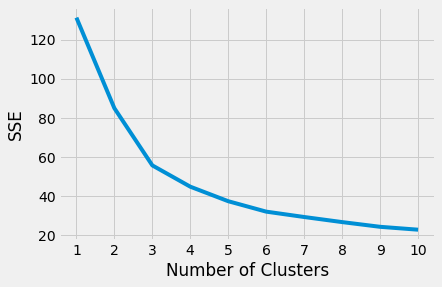

In [336]:
 plt.style.use("fivethirtyeight")
 plt.plot(range(1, 11), sse)
 plt.xticks(range(1, 11))
 plt.xlabel("Number of Clusters")
 plt.ylabel("SSE")
 plt.show()

In [338]:
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing")

kl.elbow

3

In [340]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X_train_v1)
    score = silhouette_score(X_train_v1, kmeans.labels_)
    silhouette_coefficients.append(score)

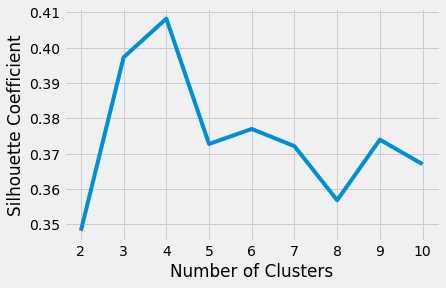

In [341]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [342]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons
from sklearn.metrics import adjusted_rand_score

In [343]:
# Instantiate k-means and dbscan algorithms
kmeans = KMeans(n_clusters=2)
dbscan = DBSCAN(eps=0.3)

# Fit the algorithms to the features
kmeans.fit(X_train_v1)
dbscan.fit(X_train_v1)

# Compute the silhouette scores for each algorithm
kmeans_silhouette = silhouette_score(
    X_train_v1, kmeans.labels_
).round(2)
dbscan_silhouette = silhouette_score(
   X_train_v1, dbscan.labels_
).round (2)

In [344]:
print(kmeans_silhouette, dbscan_silhouette)

0.35 0.06
